<a href="https://colab.research.google.com/github/subbu-art/temp-node/blob/main/QnA_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import json
import torch
from torch.utils.data import Dataset,DataLoader
import torch
import torch.nn as nn
from transformers import RobertaForQuestionAnswering, AdamW
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from transformers import AdamW
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score
from transformers import RobertaTokenizerFast
import torch
import matplotlib.pyplot as plt
from collections import Counter
from transformers import RobertaPreTrainedModel, RobertaModel

# Tokenizing the data - RoBERTa

In [ ]:
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

def tokenize_data(context, question, answer, answer_start, is_impossible, max_length=512):
    encoding = tokenizer.encode_plus(
        question, context, add_special_tokens=True, max_length=max_length,
        truncation=True, padding='max_length', return_tensors='pt'
    )
    input_ids = encoding['input_ids'].squeeze(0)
    attention_mask = encoding['attention_mask'].squeeze(0)

    start_scores = torch.zeros(len(input_ids), dtype=torch.long)
    end_scores = torch.zeros(len(input_ids), dtype=torch.long)

    if not is_impossible:
        answer_end = answer_start + len(answer)

        context_encoding = tokenizer(
            context, add_special_tokens=True, return_offsets_mapping=True,
            max_length=max_length, truncation=True
        )
        offset_mapping = context_encoding['offset_mapping']

        start_token_index = None
        end_token_index = None
        for index, (start, end) in enumerate(offset_mapping):
            if start <= answer_start < end:
                start_token_index = index
            if start < answer_end <= end:
                end_token_index = index
                break

        if start_token_index is not None and end_token_index is not None:
            start_scores[start_token_index] = 1
            end_scores[end_token_index] = 1
        else:
            # Handling the case when the answer is not found in the tokenized context
            print(f"Answer not found in tokenized context: {answer}")

        # Handling answers that are not exact substrings
        if answer.lower() not in context.lower():
            print(f"Answer is not an exact substring: {answer}")

    return input_ids, attention_mask, start_scores, end_scores

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

# Data Ingestion

In [1]:
#Loading Data
def get_data(filepath):
    with open(filepath, 'r') as file:
        data = json.load(file)
    return data

# Data Processing

In [ ]:
# Extracting feild from the input files
def data_prep(data, is_eval=False):
    processed_data = []
    num_contexts = 0
    num_questions = 0
    is_impossible_counts = Counter()
    #looping over to get Questions, Context, Answers
    for item in data['data']:
        for paragraph in item['paragraphs']:
            context = paragraph['context']
            num_contexts += 1
            for qa in paragraph['qas']:
                question = qa['question']
                is_impossible = qa['is_impossible']
                num_questions += 1
                is_impossible_counts[is_impossible] += 1
                #Ignoring qna that are impossible to retrieve
                if not is_impossible:
                    if is_eval:
                        for answer in qa['answers']:
                            answer_text = answer['text']
                            answer_start = answer['answer_start']
                            processed_data.append(tokenize_data(context, question, answer_text, answer_start, is_impossible))
                    else:
                        answer_text = qa['answers'][0]['text']
                        answer_start = qa['answers'][0]['answer_start']
                        processed_data.append(tokenize_data(context, question, answer_text, answer_start, is_impossible))
                else:
                    processed_data.append(tokenize_data(context, question, '', 0, is_impossible))

    # Visualizing Data
    visualize_statistics(num_contexts, num_questions, is_impossible_counts)

    return processed_data


# Data Insights

In [ ]:
#Vizualizing the data extracted
def visualize_statistics(num_contexts, num_questions, is_impossible_counts):
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Contexts and Questions Count
    ax[0].bar(['Contexts', 'Questions'], [num_contexts, num_questions], color=['blue', 'green'])
    ax[0].set_title('Number of Contexts and Questions')
    ax[0].set_ylabel('Count')

    # Is Impossible Count
    ax[1].bar(is_impossible_counts.keys(), is_impossible_counts.values(), color=['red', 'blue'])
    ax[1].set_xticks([False, True])
    ax[1].set_xticklabels(['Possible', 'Impossible'])
    ax[1].set_title('Number of Possible and Impossible Questions')
    ax[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


Answer not found in tokenized context: Skyfall


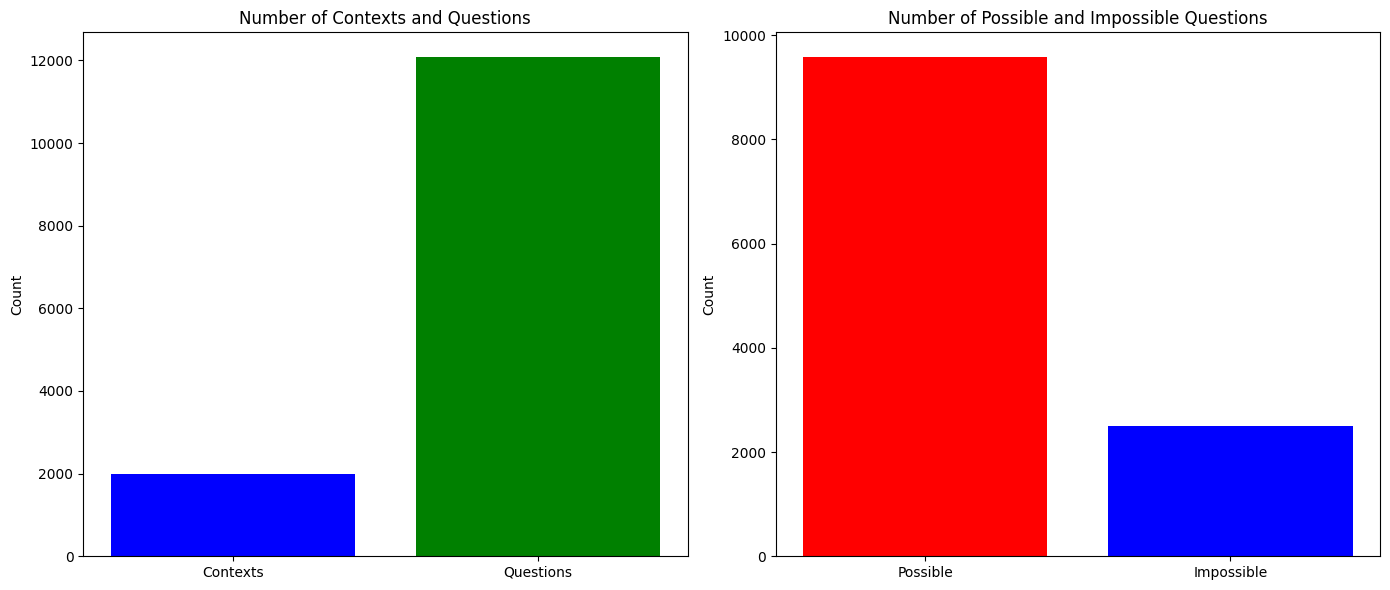

In [ ]:
train_file = 'train.json'
train_data = get_data(train_file)
train_processed = data_prep(train_data)

Answer not found in tokenized context: motorcycles or mopeds pulling trailers
Answer not found in tokenized context: motorcycles or mopeds pulling trailers
Answer not found in tokenized context: motorcycles or mopeds pulling trailers
Answer not found in tokenized context: Hendrix v Employee
Answer not found in tokenized context: Hendrix v Employee Insurance Institute
Answer not found in tokenized context: Hendrix v Employee Insurance Institute
Answer not found in tokenized context: between 3 and 14 hours a week
Answer not found in tokenized context: 3 and 14 hours a week
Answer not found in tokenized context: between 3 and 14 hours a week


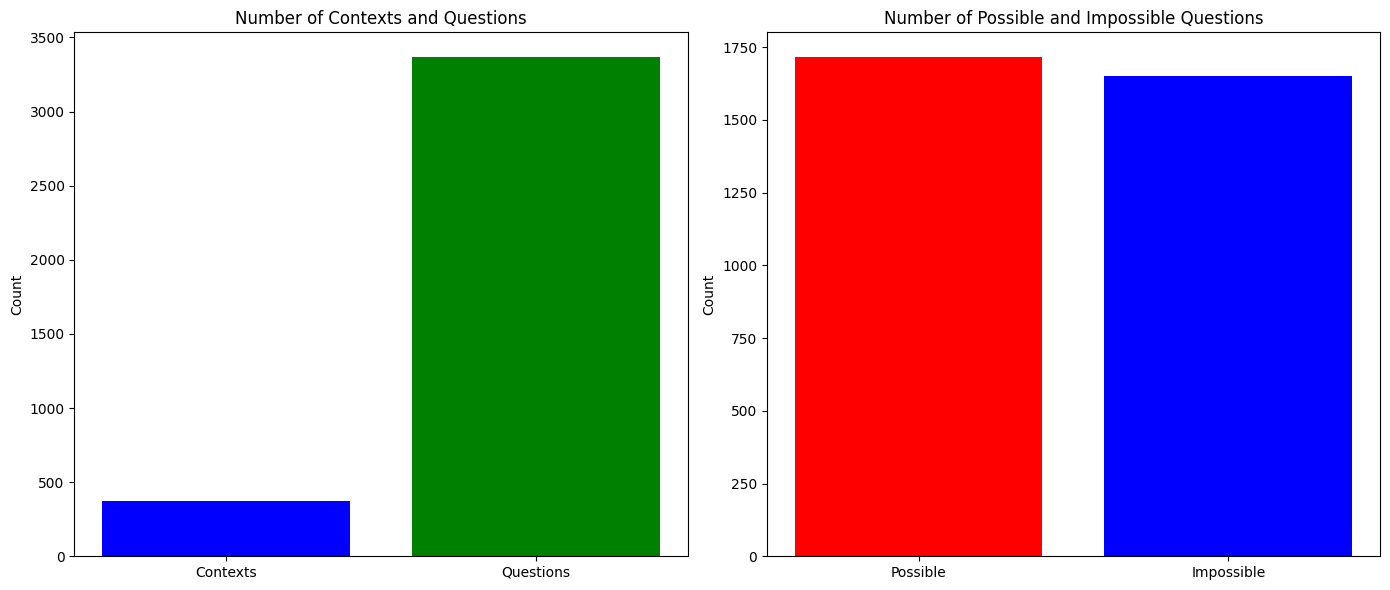

In [ ]:
eval_file = 'test.json'
eval_data = get_data(eval_file)
eval_processed = data_prep(eval_data, is_eval=True)

# Creating Dataset and Dataloaders

In [ ]:
#Creating dataset
class QADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input_ids, attention_mask, start_scores, end_scores = self.data[index]
        start_scores = start_scores.float()
        end_scores = end_scores.float()
        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'start_scores': start_scores,
            'end_scores': end_scores
        }

In [ ]:
train_dataset = QADataset(train_processed)
eval_dataset = QADataset(eval_processed)
#Creating dataloaders for train and test data to train and eval in batches
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
eval_loader = DataLoader(eval_dataset, batch_size=8, shuffle=False)

train_loader

# Model Architecture - RoBERTa

In [ ]:
#Model Architecture  for RoBERTa
class QAModel(RobertaPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.roberta = RobertaModel(config)
        self.qa_outputs = nn.Linear(config.hidden_size, 2)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.roberta(input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]
        logits = self.qa_outputs(sequence_output)
        start_logits, end_logits = logits.split(1, dim=-1)
        start_logits = start_logits.squeeze(-1).contiguous()
        end_logits = end_logits.squeeze(-1).contiguous()
        return start_logits, end_logits

## Training the Model

In [ ]:
# Training the model
def train_model(model, train_loader, eval_loader, epochs=6, learning_rate=2e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Intializing Tenorboard Writer
    writer = SummaryWriter()
    #keeping track of losses
    train_losses = []
    eval_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_scores = batch['start_scores'].to(device)
            end_scores = batch['end_scores'].to(device)

            optimizer.zero_grad()
            start_logits, end_logits = model(input_ids, attention_mask)
            loss = loss_fn(start_logits, end_logits, start_scores, end_scores)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1}/{epochs} - Average training loss: {avg_train_loss:.4f}")

        # Evaluating the model with test data
        eval_loss, start_acc, end_acc = evaluate_model(model, eval_loader, epoch)
        eval_losses.append(eval_loss)

        # Logging losses to TensorBoard
        writer.add_scalar('Training Loss', avg_train_loss, epoch)
        writer.add_scalar('Evaluation Loss', eval_loss, epoch)

        # Saving the model checkpoint for every epoch
        torch.save(model.state_dict(), 'model.pth')

    writer.close()
    return train_losses, eval_losses

## Loss Function - Cross Entropy

In [ ]:
# Loss function
def loss_fn(start_logits, end_logits, start_positions, end_positions):
    start_loss = torch.nn.functional.cross_entropy(start_logits, start_positions)
    end_loss = torch.nn.functional.cross_entropy(end_logits, end_positions)
    total_loss = (start_loss + end_loss) / 2
    return total_loss

## Evaluating the model

In [ ]:
#eval
def evaluate_model(model, eval_loader, epoch):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    eval_loss = 0
    start_preds = []
    end_preds = []
    start_labels = []
    end_labels = []
    writer = SummaryWriter()
    with torch.no_grad():
        for batch in eval_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            start_positions = batch['start_scores'].to(device)
            end_positions = batch['end_scores'].to(device)

            start_logits, end_logits = model(input_ids, attention_mask)
            loss = loss_fn(start_logits, end_logits, start_positions, end_positions)
            eval_loss += loss.item()

            start_preds.extend(torch.argmax(start_logits, dim=1).tolist())
            end_preds.extend(torch.argmax(end_logits, dim=1).tolist())
            start_labels.extend(torch.argmax(start_positions, dim=1).tolist())
            end_labels.extend(torch.argmax(end_positions, dim=1).tolist())

    eval_loss /= len(eval_loader)
    start_acc = accuracy_score(start_labels, start_preds)
    end_acc = accuracy_score(end_labels, end_preds)

    print(f"Evaluation - Average loss: {eval_loss:.4f}")
    print(f"Start Accuracy: {start_acc:.4f}")
    print(f"End Accuracy: {end_acc:.4f}")

    # Logging evaluation metrics to TensorBoard
    writer.add_scalar('Start Accuracy', start_acc, epoch)
    writer.add_scalar('End Accuracy', end_acc, epoch)

    return eval_loss, start_acc, end_acc

### Results

In [ ]:
model = QAModel.from_pretrained('roberta-base')
train_model(model, train_loader, eval_loader)

Some weights of QAModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6 - Average training loss: 3.0478
Evaluation - Average loss: 2.5340
Start Accuracy: 0.0917
End Accuracy: 0.0870
Epoch 2/6 - Average training loss: 2.2484
Evaluation - Average loss: 2.3374
Start Accuracy: 0.1216
End Accuracy: 0.1253
Epoch 3/6 - Average training loss: 1.7871
Evaluation - Average loss: 2.1527
Start Accuracy: 0.1941
End Accuracy: 0.1920
Epoch 4/6 - Average training loss: 1.4644
Evaluation - Average loss: 2.0888
Start Accuracy: 0.2295
End Accuracy: 0.1919
Epoch 5/6 - Average training loss: 1.2318
Evaluation - Average loss: 1.9712
Start Accuracy: 0.2908
End Accuracy: 0.2504
Epoch 6/6 - Average training loss: 1.0641
Evaluation - Average loss: 2.0126
Start Accuracy: 0.3181
End Accuracy: 0.3205


([3.0477944980788703,
  2.2484163015094025,
  1.7871013192546288,
  1.4643890003297502,
  1.2318121027275426,
  1.0641406558799429],
 [2.5340142384611606,
  2.337409233525081,
  2.1527363171541616,
  2.0888455835512922,
  1.9712404712625948,
  2.0126448799109378])

## Loss and Accuracy curves

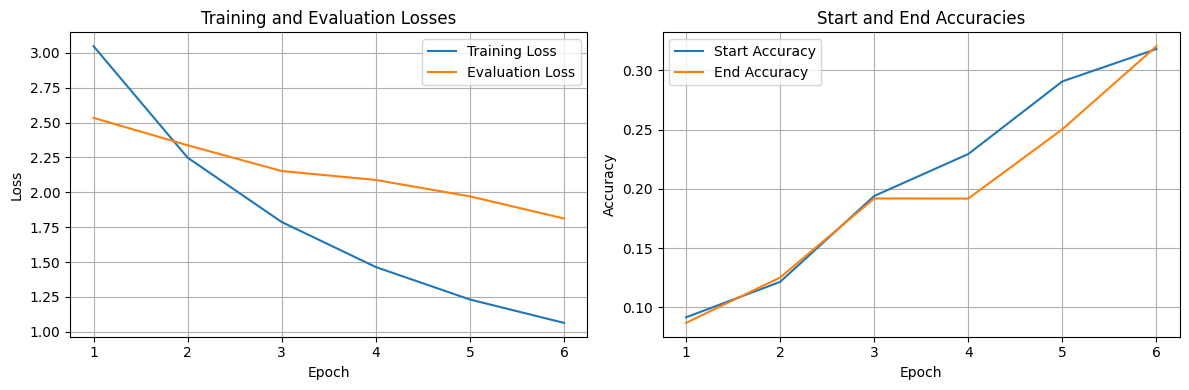

In [ ]:
def plot_metrics(train_losses, eval_losses, start_accuracies, end_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plotting losses
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, eval_losses, label='Evaluation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Evaluation Losses')
    plt.legend()
    plt.grid(True)

    # Plotting accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, start_accuracies, label='Start Accuracy')
    plt.plot(epochs, end_accuracies, label='End Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Start and End Accuracies')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_metrics(train_losses, eval_losses, start_accuracies, end_accuracies)

## Infrencing

In [ ]:
def inference(model, tokenizer, question, context):
    # Tokenizing the input question and context
    encoded_inputs = tokenizer(question, context, max_length=512, padding='max_length', truncation=True, return_tensors='pt')
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Setting the model to evaluation mode
    model.eval()

    with torch.no_grad():
        # Forward pass through the model
        outputs = model(input_ids, attention_mask=attention_mask)
        start_logits, end_logits = outputs

        # Finding the starting and ending tokens with the highest logits
        start_index = torch.argmax(start_logits)
        end_index = torch.argmax(end_logits)

        # Converting the token indices to the actual answer span
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
        answer_tokens = tokens[start_index : end_index + 1]
        answer = tokenizer.convert_tokens_to_string(answer_tokens)

    return answer

# Load the trained model
config = RobertaConfig.from_pretrained('roberta-base')
model = QAModel(config)

# Loading the trained model state dictionary
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Loading the RoBERTa tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Example usage
context = """
France is a country located in Western Europe. It is known for its rich history, cultural heritage, and iconic landmarks.
The capital and largest city of France is Paris, often referred to as the "City of Light." Paris is renowned for its fashion,
cuisine, art, and architecture. Some of the famous landmarks in Paris include the Eiffel Tower, the Louvre Museum, and the
Cathedral of Notre-Dame.

France is also known for its diverse regions, each with its own unique charm and attractions. The French Riviera, located on
the Mediterranean coast, is a popular tourist destination with its glamorous beaches and resort towns like Nice and Cannes.
The region of Provence is famous for its picturesque lavender fields, olive groves, and charming villages.

The French Alps, located in the eastern part of the country, offer stunning mountain landscapes and world-class ski resorts.
The region of Normandy, in the north, is known for its historic sites related to World War II, such as the D-Day beaches and
the Mont-Saint-Michel abbey.

France is also renowned for its cuisine, which is considered one of the finest in the world. French gastronomy is characterized
by its use of fresh, high-quality ingredients and its emphasis on flavor and presentation. Some famous French dishes include
croissants, baguettes, escargots, coq au vin, and crème brûlée.

Overall, France is a country with a rich cultural heritage, stunning landscapes, and a renowned cuisine, making it a popular
destination for tourists from around the world.
"""

questions = [
    "What are some famous landmarks in Paris?",
    "Where is the French Riviera located?",
    "What is the region of Provence known for?",
    "What historic sites are located in the region of Normandy?",
    "Name some famous French dishes.",
]

for question in questions:
    answer = inference(model, tokenizer, question, context)
    print("Question:", question)
    print("Answer:", answer)
    print()

Question: What are some famous landmarks in Paris?
Answer:  architecture. Some of the famous landmarks in Paris include the Eiffel Tower, the Louvre Museum,

Question: Where is the French Riviera located?
Answer:  attractions. The

Question: What is the region of Provence known for?
Answer:  Cannes. 
The region of Provence is famous for

Question: What historic sites are located in the region of Normandy?
Answer: , in the north, is known for its historic sites related to World War II, such as the D-Day beaches

Question: Name some famous French dishes.
Answer:  flavor and presentation. Some famous French dishes include 
croissants, baguettes, escargots, coq au vin



In [ ]:
from google.colab import files
import shutil
shutil.make_archive("runs", "zip", "runs")

# Downloading tesnorboard outputs
files.download("runs.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Save the model
torch.save(model.state_dict(), 'model.pth')

# Downloading model file
files.download('model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip freeze > requirements.txt

In [ ]:
from google.colab import files
files.download('requirements.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>